In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
import preprocessing as pp

In [7]:
RANDOM_STATE = 0

In [6]:
df = pd.read_csv('../data_exploration/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Preprocessing with pipelines

In [8]:
pipeline_df = Pipeline(steps=[
    ('new_features', pp.New_features()),
    ('drop_outliers', pp.Drop_outliers()),
    #('drop_outliers', Drop_all_outliers()),
    ('drop_rows', pp.Drop_target())
])

df2 = pipeline_df.fit_transform(df)

In [10]:
target = 'median_house_value'
y = df2[target]
X = df2.drop(columns=target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_STATE)

In [11]:
categorical_cols = X_train.select_dtypes(exclude=np.number).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency = 0.12))
])

numerical_cols = X_train.select_dtypes(include=np.number).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

pp_X_train = preprocessor.fit_transform(X_train)
pp_X_test = preprocessor.transform(X_test)

### Modeling

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(RandomForestRegressor(), pp_X_train, y_train).mean()

0.8058500257386371

In [20]:
cross_val_score(DecisionTreeRegressor(), pp_X_train, y_train).mean()

0.6031659937861233

In [21]:
cross_val_score(LinearRegression(), pp_X_train, y_train).mean()

0.642599092204443

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

In [23]:
model_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 250, 300],
        }
    },
     'DecisionTreeRegressor': {
         'model': DecisionTreeRegressor(),
         'params': {
             'max_depth': [5,7,10,20,50,100,150]
         }
     },
     'LinearRegression': {
         'model': LinearRegression(),
         'params': {}
     }
 
}

In [24]:
%%time

scores = []

for model_name, mp in model_params.items():
    mod =  GridSearchCV(mp['model'], mp['params'], cv=5)
    mod.fit(pp_X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': mod.best_score_,
        'best_params': mod.best_params_
    })
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

CPU times: user 4min 41s, sys: 1.12 s, total: 4min 42s
Wall time: 4min 41s


,model,best_score,best_params
0,RandomForestRegressor,0.807370,{'n_estimators': 300}
1,DecisionTreeRegressor,0.683688,{'max_depth': 7}
2,LinearRegression,0.642599,{}


In [25]:
# Tuning Random Forest Regressor
scores_train = []
scores_test = []
estimators = np.arange(200,370,20)

for e in estimators:
    model = RandomForestRegressor(n_estimators = e)
    model.fit(pp_X_train,y_train)
    y_test_pred = model.predict(pp_X_test)
    scores_test.append(mean_absolute_error(y_test, y_test_pred))

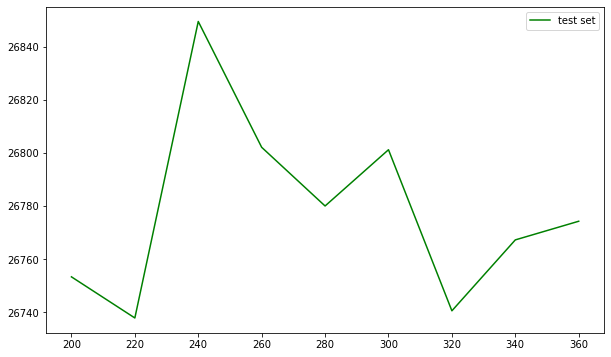

In [26]:
plt.figure(figsize=(10,6))
plt.plot(estimators,scores_test,color='g', label='test set')
plt.legend()

In [36]:
mod_rf = RandomForestRegressor(n_estimators=320)
mod_dt = DecisionTreeRegressor(max_depth=7)
mod_lr = LinearRegression()

In [37]:
mod_rf.fit(pp_X_train,y_train)
mod_dt.fit(pp_X_train,y_train)
mod_lr.fit(pp_X_train,y_train)

LinearRegression()

In [38]:
print(mod_rf.score(pp_X_test,y_test))
print(mod_dt.score(pp_X_test,y_test))
print(mod_lr.score(pp_X_test,y_test))

0.8257316693815011
0.7084459174788091
0.6658337419256939


In [39]:
y_pred_rf = mod_rf.predict(pp_X_test)
score_rf = mean_absolute_error(y_test, y_pred_rf)
print('MAE:', score_rf)
y_pred_dt = mod_dt.predict(pp_X_test)
score_dt = mean_absolute_error(y_test, y_pred_dt)
print('MAE:', score_dt)
y_pred_lr = mod_lr.predict(pp_X_test)
score_lr = mean_absolute_error(y_test, y_pred_lr)
print('MAE:', score_lr)

MAE: 26755.999214625135
MAE: 36581.88456829316
MAE: 41446.41761813622


<BarContainer object of 13 artists>

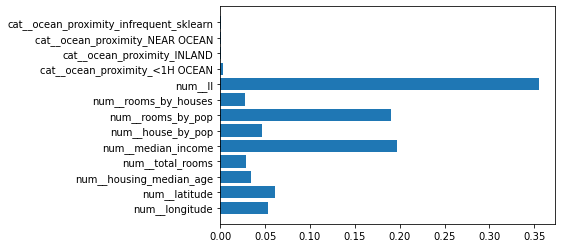

In [40]:
plt.barh(preprocessor.get_feature_names_out(), mod_rf.feature_importances_)